# Stats

> Statistics on lensing data

In [1]:
#| default_exp parameters

In [2]:
#| hide
from nbdev.showdoc import *

In [19]:
#| export
import numpy as np
from scipy.stats import poisson, norm
from scipy.optimize import minimize
import matplotlib.pyplot as plt

## Toy Model for Mass likelihood

In [583]:
#| export
# Define the power law function with index -2
def power_law(x, a=1, index=-2):
    return a * (x**index)

# Define the likelihood function for the Poisson process
def likelihood(observed_counts, expected_counts):
    poisson_pmf = poisson.pmf(observed_counts, expected_counts)
    return np.prod(poisson_pmf)

# Generate an example set of binned observations with a bump
def generate_observed_counts_with_bump(bin_centers, a, bump_center, bump_width, bump_height):
    power_law_counts = power_law(bin_centers, a=a)
    bump = norm.pdf(bin_centers, bump_center, bump_width) * bump_height
    return np.random.poisson(power_law_counts + bump)

In [584]:
# Generate an example set of binned observations
np.random.seed(42)

bin_edges = np.arange(1, 12)  # Assuming 10 bins with equal width
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
a = 50  # Scale factor to match the example observed_counts
bump_center = 5  # Bump location
bump_width = 0.5  # Bump width
bump_height = 20  # Bump height

observed_counts = generate_observed_counts_with_bump(bin_centers, a, bump_center, bump_width, bump_height)

# Calculate the expected counts based on the power law model
expected_counts = power_law(bin_centers, a=a)

# Calculate the total likelihood
total_likelihood = likelihood(observed_counts, expected_counts)

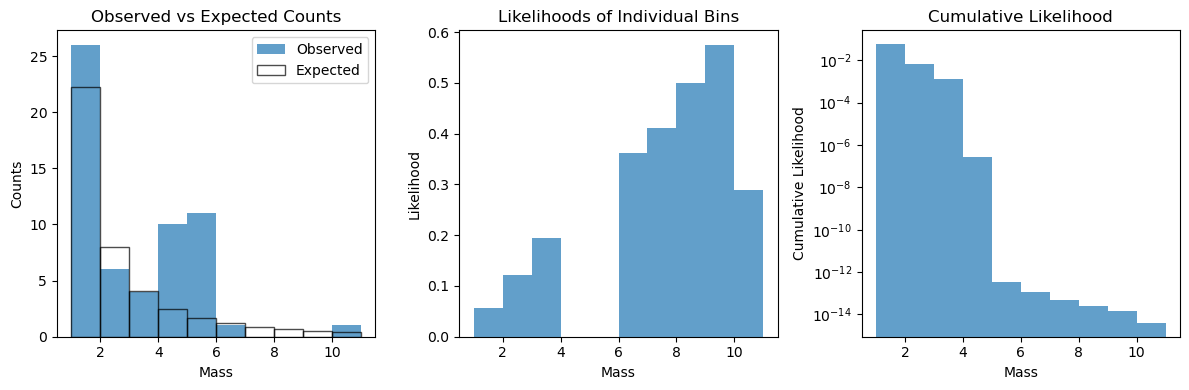

In [585]:
# Plot the observed and expected counts
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.bar(bin_centers, observed_counts, width=1, alpha=0.7, label="Observed")
plt.bar(bin_centers, expected_counts, width=1, alpha=0.7, label="Expected", edgecolor='black', linewidth=1, fill=False)
plt.xlabel("Mass")
plt.ylabel("Counts")
plt.legend()
plt.title("Observed vs Expected Counts")

# Plot the likelihoods of individual bins
likelihoods = poisson.pmf(observed_counts, expected_counts)
plt.subplot(132)
plt.bar(bin_centers, likelihoods, width=1, alpha=0.7)
plt.xlabel("Mass")
plt.ylabel("Likelihood")
plt.title("Likelihoods of Individual Bins")

# Plot the cumulative likelihood
cumulative_likelihood = np.cumprod(likelihoods)
plt.subplot(133)
plt.bar(bin_centers, cumulative_likelihood, width=1, alpha=0.7)
plt.xlabel("Mass")
plt.ylabel("Cumulative Likelihood")
plt.yscale("log")
plt.title("Cumulative Likelihood")

plt.tight_layout()
plt.show()

## MLE

In [586]:
import numpy as np
from scipy.stats import poisson, norm
from scipy.optimize import minimize

In [604]:
# Define the likelihood function for the Poisson process
def likelihood(observed_counts, expected_counts):
    poisson_pmf = poisson.pmf(observed_counts, expected_counts)
    # print(observed_counts, expected_counts)
    return np.prod(poisson_pmf)

# Define the negative log-likelihood function for optimization with continuous bump_position
def neg_log_likelihood(params, bin_centers, observed_counts):
    a, index, bump_position, bump_height = params
    expected_counts = power_law(bin_centers, a=a, index=index)
    closest_bin = np.argmin(np.abs(bin_centers - bump_position))
    expected_counts[closest_bin] += bump_height
    return -np.log(likelihood(observed_counts, expected_counts)).sum()

# Generate an example set of binned observations with a bump
def generate_observed_counts_with_bump(bin_centers, a, index, bump_position, bump_height):
    power_law_counts = power_law(bin_centers, a=a, index=index)
    closest_bin = np.argmin(np.abs(bin_centers - bump_position))
    power_law_counts[closest_bin] += bump_height
    return np.random.poisson(power_law_counts)

min_bin = 1
max_bin = 10
bin_edges = np.linspace(min_bin,max_bin,10)  # Assuming bins from -6 to -2

bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

a = 200
index = -2
bump_position = 6
bump_height = 50

observed_counts = generate_observed_counts_with_bump(bin_centers, a, index, bump_position, bump_height)

# Optimize the negative log-likelihood
initial_guess = [150, -2, 5, 10]
expected_counts = generate_observed_counts_with_bump(bin_centers, *initial_guess)
bounds = [(1e-6, None), (-4, -1), (min_bin, max_bin), (0, None)]

result = minimize(neg_log_likelihood, initial_guess, args=(bin_centers, observed_counts), bounds=bounds, options={"maxiter": 10000}, tol=1e-4)
optimized_params = result.x
print("Optimized parameters: a = {:.2f}, index = {:.2f}, bump_position = {:.2e}, bump_height = {:.2f}".format(*optimized_params))

# Calculate the expected counts based on the optimized parameters
a_opt, index_opt, bump_position_opt, bump_height_opt = optimized_params
expected_counts_opt = generate_observed_counts_with_bump(bin_centers, *optimized_params)
closest_bin = np.argmin(np.abs(bin_centers - bump_position_opt))
expected_counts_opt[closest_bin] += bump_height_opt

Optimized parameters: a = 151.12, index = -1.80, bump_position = 5.57e+00, bump_height = 50.17


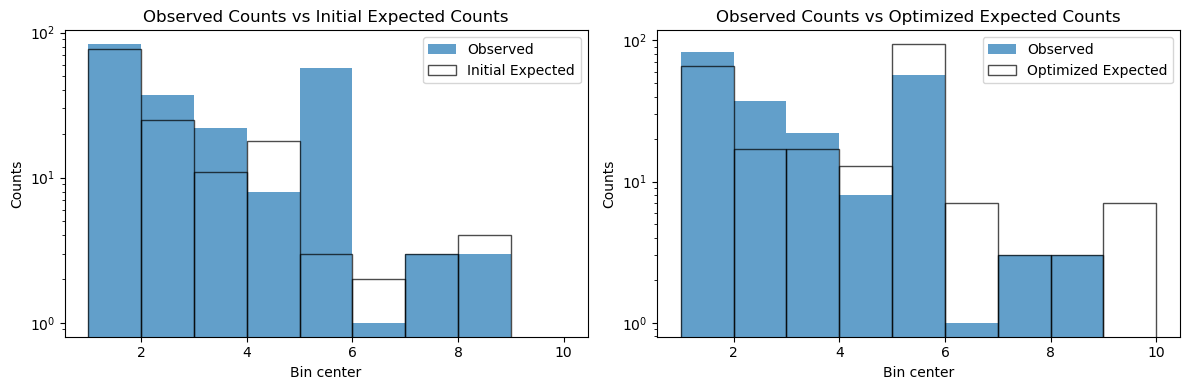

In [605]:
# Plot the observed counts and the initial/optimized expected counts
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.bar(bin_centers, observed_counts,  width=1, alpha=0.7, label="Observed")
plt.bar(bin_centers, expected_counts, width=1, alpha=0.7, label="Initial Expected", edgecolor='black', linewidth=1, fill=False)
plt.xlabel("Bin center")
plt.ylabel("Counts")
# plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.title("Observed Counts vs Initial Expected Counts")

plt.subplot(122)
plt.bar(bin_centers, observed_counts, width=1, alpha=0.7, label="Observed")
plt.bar(bin_centers, expected_counts_opt, width=1, alpha=0.7, label="Optimized Expected", edgecolor='black', linewidth=1, fill=False)
plt.xlabel("Bin center")
plt.ylabel("Counts")
# plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.title("Observed Counts vs Optimized Expected Counts")

plt.tight_layout()
plt.show()

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()